Importing Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import random
import os
import base64
import copy
import csv
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
random.seed(a=1234567)

2023-08-21 14:11:47.980498: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Preprocessing CAN Dataset

In [2]:
#User inputs
no_of_2_grams = 256 #Number of 2-gram TF-IDF features
no_of_3_grams = 0 #Number of 3-gram TF-IDF features
input_type = "Char" #Byte, Char or All
take_id = True #Take CAN ID as a feature

# Set the input CSV file 
# Make sure it is in correct format with following columns in the order - ID, Data, Label
input_csv_file = 'dataset_csv/Attack_Dataset_Driving_no_duplicates.csv'

In [3]:
# The output csv file path to save csv without id column
dataset_file_no_id = 'dataset_csv/temp/Attacks_D_Sliding_Window_no_id.csv'

# Open the input and output files
with open(input_csv_file, 'r') as file_in, open(dataset_file_no_id, 'w', newline='') as file_out:
    # Create CSV reader and writer objects
    reader = csv.reader(file_in)
    writer = csv.writer(file_out)
    
    # Iterate over the rows in the input file
    for row in reader:
        # Write all columns except the first one to the output file
        writer.writerow(row[1:])

In [4]:
# The output csv file path to save csv with only id column
if take_id:
    # Specify the input and output file paths
    dataset_file_all_id = 'dataset_csv/temp/Attacks_D_Sliding_Window_all_id.csv'

    # Open the input and output files
    with open(input_csv_file, 'r') as file_in, open(dataset_file_all_id, 'w', newline='') as file_out:
        # Create CSV reader and writer objects
        reader = csv.reader(file_in)
        writer = csv.writer(file_out)

        # Iterate over the rows in the input file
        for row in reader:
            # Write all columns except the first one to the output file
            writer.writerow(row[0])

In [5]:
# Convert the CSV file to Text file and Save another csv with only Labels
Labels_FileName = 'dataset_csv/temp/Sliding_Window_Labels.csv'
Binaries_FileName = 'dataset_csv/temp/Vectors.txt'

with open(dataset_file_no_id, 'r') as infile:
  Sliding_Window_List = []
  for line in infile:
    Sliding_Window_List.append(line.strip())

Sliding_Window_List = [Sliding_Window_List[ii].replace(",", " ") for ii in range(0, len(Sliding_Window_List))]
print(Sliding_Window_List[0])
print(Sliding_Window_List[1])

# Open the CSV file in write mode
with open(Labels_FileName, 'w', newline='') as file:
    # Create a CSV writer object
    csv_writer = csv.writer(file)

    # Write each row with the same value
    for lst in Sliding_Window_List:
        csv_writer.writerow([lst.rsplit(' ', 1)[1]])

#We need to change this for other labels
Sliding_Window_Vector = [lst.rsplit(' ', 1)[0] for lst in Sliding_Window_List]
print(Sliding_Window_Vector[1])

#Write all binaries without labels in file
with open(Binaries_FileName, 'w') as f:
    for row in Sliding_Window_Vector:
        f.write(''.join(map(str, row)) + '\n')

C5 00 FC 00 C7 00 8D 0A Spoofing
00 00 08 06 00 DE 7A C0 Spoofing
00 00 08 06 00 DE 7A C0


In [6]:
if take_id:
    min_value = 0
    max_value = 2048
    with open(dataset_file_all_id, 'r') as infile:
        Id_List = []
        for line in infile:
            Id_List.append(line.strip())

    Id_List = [Id_List[ii].replace(",", "") for ii in range(0, len(Id_List))]
    Id_List = [int(Id_List[ii],16) for ii in range(0, len(Id_List))]
    Id_List = [(x - min_value) / (max_value - min_value) for x in Id_List]    
    print(len(Id_List))

709962


In [7]:
from collections import defaultdict, Counter

label_counter = Counter()
num_duplicates = 0
label_list = []

with open(Binaries_FileName,"r") as raw_binaries_file, open(Labels_FileName,"r") as binaries_label_file:
    for _, label_value_tmp in zip(raw_binaries_file, binaries_label_file):
        label_value = label_value_tmp.rstrip('\n')
        label_counter[label_value] += 1
        label_list.append(label_value)

# We're using a Counter object, so we can simply print its items
print('Distinct Labels:', label_counter.keys())
print('Label Info:', label_counter.values())

min_len = min(label_counter.values()) 
print('Minimum number of data points in a class:', min_len)

# Convert string labels to integers
labels_to_integers = {label: i for i, label in enumerate(label_counter.keys())} #labels_to_integers
label_list_numeric = [labels_to_integers[label] for label in label_list]
class_data_info = defaultdict(list)

#Collecting indices belong to each class 
for i, label in enumerate(label_counter.keys()):
    class_data_info[labels_to_integers[label]].append(i)

print(class_data_info)

class_data_info = []
for ii in range(0, len(label_counter.keys())):
    class_data_info.append([])

#Collecting indices belong to each class
for ii in range(0, len(label_list)):
    class_data_info[label_list_numeric[ii]].append(ii)

print('Label to Integer Info:', labels_to_integers)

Distinct Labels: dict_keys(['Spoofing', 'Normal', 'Fuzzing'])
Label Info: dict_values([164410, 500078, 45474])
Minimum number of data points in a class: 45474
defaultdict(<class 'list'>, {0: [0], 1: [1], 2: [2]})
Label to Integer Info: {'Spoofing': 0, 'Normal': 1, 'Fuzzing': 2}


Splitting Training and Testing Data

In [8]:
#Train Test Split
train_dps_per_class = int(min_len*0.8)
test_dps_per_class = min_len - train_dps_per_class

print('Number of training data per class:', train_dps_per_class)
print('Number of testing data per class:', test_dps_per_class)

Number of training data per class: 36379
Number of testing data per class: 9095


Data Balancing

In [9]:
# Collecting same number of samples for each class of architecture -> (Data Balancing in each class)
picked_data_indices_train = [[] for _ in range(len(labels_to_integers))]
picked_data_indices_test = [[] for _ in range(len(labels_to_integers))]

for ii in range(len(labels_to_integers)):
    train_dps = min(train_dps_per_class, len(class_data_info[ii]))
    test_dps = min(test_dps_per_class, len(class_data_info[ii]) - train_dps)

    if train_dps > 0:
        picked_data_indices_train[ii] += random.sample(class_data_info[ii], train_dps)
        class_data_info[ii] = list(set(class_data_info[ii]).difference(set(picked_data_indices_train[ii])))
    
    if test_dps > 0:
        picked_data_indices_test[ii] += random.sample(class_data_info[ii], test_dps)
        class_data_info[ii] = list(set(class_data_info[ii]).difference(set(picked_data_indices_test[ii])))

Binaries_DataSets_train = []
Binaries_DataSets_test = []
Binaries_LabelSets_train = []
Binaries_LabelSets_test = []
Binaries_IdSets_train = []
Binaries_IdSets_test = []

for ii in range(0, len(labels_to_integers)):
    Binaries_DataSets_train += [Sliding_Window_Vector[index] for index in picked_data_indices_train[ii]]
    Binaries_LabelSets_train += [label_list[index] for index in picked_data_indices_train[ii]]
    Binaries_DataSets_test += [Sliding_Window_Vector[index] for index in picked_data_indices_test[ii]]
    Binaries_LabelSets_test += [label_list[index] for index in picked_data_indices_test[ii]]
    
    if take_id:
        Binaries_IdSets_train += [Id_List[index] for index in picked_data_indices_train[ii]]
        Binaries_IdSets_test += [Id_List[index] for index in picked_data_indices_test[ii]]

with open("DistinctLabels.txt", "wb") as fp:   #Pickling
    pickle.dump(labels_to_integers, fp)

### (2) Byte-level N-Gram TF-IDF Features
Extract (1,2,3)-Gram TF-IDF features from binaries in Hex format

In [10]:
#Function to concatenate two pandas dataframes with unique column names
def concat_dfs(df1, df2):    
    shift_value = df1.shape[1]
    column_reindex = []
    
    for ii in range(0,df2.shape[1]):
        column_reindex.append(str(ii+shift_value))

    dictOfColumn_reindex = { ii : column_reindex[ii] for ii in range(0, len(column_reindex)) }
    df2 = df2.rename(dictOfColumn_reindex, axis='columns')
    df = pd.concat([df1, df2], axis = 1)

    return df

In [11]:
#Calculate N-gram Byte level features for N = 1,2,3 based on user input and concatenate into one dataframe
if input_type == "Byte":
    vectorizer_12 = TfidfVectorizer(ngram_range = (1,1), lowercase = False)
    #fit TF-IDF model using training data and transform training data according to the fitted model
    X_train_12 = vectorizer_12.fit_transform(Binaries_DataSets_train)
    df_train_Byte_TFIDF_feat_12 = pd.DataFrame(X_train_12.toarray())
    df_train_Byte_TFIDF_feat_12['label'] = Binaries_LabelSets_train

    ## Transform test data using the fitted model
    X_test_12 = vectorizer_12.transform(Binaries_DataSets_test)
    df_test_Byte_TFIDF_feat_12 = pd.DataFrame(X_test_12.toarray())
    df_test_Byte_TFIDF_feat_12['label'] = Binaries_LabelSets_test
    if take_id:
        df_train_Byte_TFIDF_feat_12['id'] = Binaries_IdSets_train
        df_test_Byte_TFIDF_feat_12['id'] = Binaries_IdSets_test

    #For no concatenation case
    if no_of_2_grams == 0 and no_of_3_grams == 0:
        df_train_Byte_TFIDF_feat = df_train_Byte_TFIDF_feat_12
        df_test_Byte_TFIDF_feat = df_test_Byte_TFIDF_feat_12

    if no_of_2_grams > 0:
        vectorizer_22 = TfidfVectorizer(ngram_range = (2,2), max_features = no_of_2_grams, lowercase = False)
        #fit TF-IDF model using training data and transform training data according to the fitted model
        X_train_22 = vectorizer_22.fit_transform(Binaries_DataSets_train)
        df_train_Byte_TFIDF_feat_22 = pd.DataFrame(X_train_22.toarray())

        #transform test data using the fitted model
        X_test_22 = vectorizer_22.transform(Binaries_DataSets_test)
        df_test_Byte_TFIDF_feat_22 = pd.DataFrame(X_test_22.toarray())

    if no_of_3_grams > 0:
        vectorizer_3 = TfidfVectorizer(ngram_range = (3,3),max_features = no_of_3_grams,lowercase = False)
        #fit TF-IDF model using training data and transform training data according to the fitted model
        X_train_3 = vectorizer_3.fit_transform(Binaries_DataSets_train)
        df_train_Byte_TFIDF_feat_3 = pd.DataFrame(X_train_3.toarray())

        # #transform test data using the fitted model
        X_test_3 = vectorizer_3.transform(Binaries_DataSets_test)
        df_test_Byte_TFIDF_feat_3 = pd.DataFrame(X_test_3.toarray())

    # For Concatenation case
    if no_of_2_grams > 0:
        df_train_Byte_TFIDF_feat = concat_dfs(df_train_Byte_TFIDF_feat_12, df_train_Byte_TFIDF_feat_22)
        df_test_Byte_TFIDF_feat = concat_dfs(df_test_Byte_TFIDF_feat_12, df_test_Byte_TFIDF_feat_22)

    if no_of_2_grams > 0 and no_of_3_grams > 0:
        df_train_Byte_TFIDF_feat = concat_dfs(df_train_Byte_TFIDF_feat, df_train_Byte_TFIDF_feat_3)
        df_test_Byte_TFIDF_feat = concat_dfs(df_test_Byte_TFIDF_feat, df_test_Byte_TFIDF_feat_3)

    if no_of_3_grams > 0 and no_of_2_grams == 0:
        df_train_Byte_TFIDF_feat = concat_dfs(df_train_Byte_TFIDF_feat_12, df_train_Byte_TFIDF_feat_3)
        df_test_Byte_TFIDF_feat = concat_dfs(df_test_Byte_TFIDF_feat_12, df_test_Byte_TFIDF_feat_3)

    df_train_Byte_TFIDF_feat = df_train_Byte_TFIDF_feat.sample(frac=1)
    df_test_Byte_TFIDF_feat = df_test_Byte_TFIDF_feat.sample(frac=1)

Data processing for Character level TF-IDF

In [12]:
#Remove all spaces in data field for calculating character level features
Binaries_DataSets_train_B16 = [Binaries_DataSets_train[ii].replace(" ", "") for ii in range(0, len(Binaries_DataSets_train))]
Binaries_DataSets_test_B16 = [Binaries_DataSets_test[ii].replace(" ", "") for ii in range(0, len(Binaries_DataSets_test))]

Character level (1,2,3)-gram TF-IDF (Change list parameters after discussion)

In [13]:
#Calculate N-gram Character level features for N = 1,2,3 based on user input and concatenate into one dataframe
if input_type == "Char":
    vectorizer_11_B16 = TfidfVectorizer(ngram_range = (1,1), lowercase = False, analyzer = 'char')
    #fit TF-IDF model using training data and transform training data according to the fitted model
    X_train_11_B16 = vectorizer_11_B16.fit_transform(Binaries_DataSets_train_B16)
    df_train_CharB16_TFIDF_feat_11 = pd.DataFrame(X_train_11_B16.toarray())
    df_train_CharB16_TFIDF_feat_11['label'] = Binaries_LabelSets_train
    
    #transform test data using the fitted model
    X_test_11_B16 = vectorizer_11_B16.transform(Binaries_DataSets_test_B16)
    df_test_CharB16_TFIDF_feat_11 = pd.DataFrame(X_test_11_B16.toarray())
    df_test_CharB16_TFIDF_feat_11['label'] = Binaries_LabelSets_test
    
    if take_id:
        df_train_CharB16_TFIDF_feat_11['id'] = Binaries_IdSets_train
        df_test_CharB16_TFIDF_feat_11['id'] = Binaries_IdSets_test
    ##For no concat
    if no_of_2_grams == 0 and no_of_3_grams == 0:
        df_train_Char_TFIDF_feat = df_train_CharB16_TFIDF_feat_11
        df_test_Char_TFIDF_feat = df_test_CharB16_TFIDF_feat_11

    if no_of_2_grams > 0:
        vectorizer_22_B16 = TfidfVectorizer(ngram_range = (2,2), max_features = no_of_2_grams, lowercase = False, analyzer = 'char')
        #fit TF-IDF model using training data and transform training data according to the fitted model
        X_train_22_B16 = vectorizer_22_B16.fit_transform(Binaries_DataSets_train_B16)
        df_train_CharB16_TFIDF_feat_22 = pd.DataFrame(X_train_22_B16.toarray())

        #transform test data using the fitted model
        X_test_22_B16 = vectorizer_22_B16.transform(Binaries_DataSets_test_B16)
        df_test_CharB16_TFIDF_feat_22 = pd.DataFrame(X_test_22_B16.toarray())

    if no_of_3_grams > 0:
        vectorizer_33_B16 = TfidfVectorizer(ngram_range = (3,3), max_features = no_of_3_grams, lowercase = False, analyzer = 'char')
        #fit TF-IDF model using training data and transform training data according to the fitted model
        X_train_33_B16 = vectorizer_33_B16.fit_transform(Binaries_DataSets_train_B16)
        df_train_CharB16_TFIDF_feat_33 = pd.DataFrame(X_train_33_B16.toarray())

        #transform test data using the fitted model
        X_test_33_B16 = vectorizer_33_B16.transform(Binaries_DataSets_test_B16)
        df_test_CharB16_TFIDF_feat_33 = pd.DataFrame(X_test_33_B16.toarray())
    
    # Concatenations 
    if no_of_2_grams > 0:
        df_train_Char_TFIDF_feat = concat_dfs(df_train_CharB16_TFIDF_feat_11, df_train_CharB16_TFIDF_feat_22)
        df_test_Char_TFIDF_feat = concat_dfs(df_test_CharB16_TFIDF_feat_11, df_test_CharB16_TFIDF_feat_22)
    
    if no_of_2_grams > 0 and no_of_3_grams > 0:
        df_train_Char_TFIDF_feat = concat_dfs(df_train_Char_TFIDF_feat, df_train_CharB16_TFIDF_feat_33)
        df_test_Char_TFIDF_feat = concat_dfs(df_test_Char_TFIDF_feat, df_test_CharB16_TFIDF_feat_33)

    if no_of_3_grams > 0 and no_of_2_grams == 0:
        df_train_Char_TFIDF_feat = concat_dfs(df_train_CharB16_TFIDF_feat_11, df_train_CharB16_TFIDF_feat_33)
        df_test_Char_TFIDF_feat = concat_dfs(df_test_CharB16_TFIDF_feat_11, df_test_CharB16_TFIDF_feat_33)

    df_train_Char_TFIDF_feat = df_train_Char_TFIDF_feat.sample(frac=1)
    df_test_Char_TFIDF_feat = df_test_Char_TFIDF_feat.sample(frac=1)

In [14]:
#Convert all pandas data frames to numpy arrays
if input_type=="Char":
    df_train_Byte_TFIDF_feat_label_convert = df_train_Char_TFIDF_feat.replace({'label' : labels_to_integers})
    df_train_Byte_TFIDF_feat_no_label = df_train_Byte_TFIDF_feat_label_convert.drop('label', axis=1)
    inputs = df_train_Byte_TFIDF_feat_no_label.to_numpy()
    outputs_string = df_train_Char_TFIDF_feat['label'].to_numpy()

    df_test_Byte_TFIDF_feat_label_convert = df_test_Char_TFIDF_feat.replace({'label' : labels_to_integers})
    df_test_Byte_TFIDF_feat_no_label = df_test_Byte_TFIDF_feat_label_convert.drop('label', axis=1)
    inputs_test = df_test_Byte_TFIDF_feat_no_label.to_numpy()
    outputs_string_test = df_test_Char_TFIDF_feat['label'].to_numpy()
else:
    df_train_Byte_TFIDF_feat_label_convert = df_train_Byte_TFIDF_feat.replace({'label' : labels_to_integers})
    df_train_Byte_TFIDF_feat_no_label = df_train_Byte_TFIDF_feat_label_convert.drop('label', axis=1)
    inputs = df_train_Byte_TFIDF_feat_no_label.to_numpy()
    outputs_string = df_train_Byte_TFIDF_feat['label'].to_numpy()

    df_test_Byte_TFIDF_feat_label_convert = df_test_Byte_TFIDF_feat.replace({'label' : labels_to_integers})
    df_test_Byte_TFIDF_feat_no_label = df_test_Byte_TFIDF_feat_label_convert.drop('label', axis=1)
    inputs_test = df_test_Byte_TFIDF_feat_no_label.to_numpy()
    outputs_string_test = df_test_Byte_TFIDF_feat['label'].to_numpy()

In [15]:
#Set random seed
np.random.seed(30)
tf.random.set_seed(30)

In [16]:
#Convert inputs to float32 type
X_train = inputs.astype('float32')
X_test = inputs_test.astype('float32')

Change this logic for multiclass

In [17]:
#Convert labels to integers
mapping = labels_to_integers

Y_train1 = outputs_string
Y_test1 = outputs_string_test
# Replace values using numpy.where()
for integer in labels_to_integers.keys():
    Y_train1 = np.where(Y_train1 == integer, mapping[integer], Y_train1)
    Y_test1 = np.where(Y_test1 == integer, mapping[integer], Y_test1)

In [18]:
#Convert labels to categorical
num_labels=len(labels_to_integers.keys())
Y_train = tf.keras.utils.to_categorical(Y_train1, num_classes=num_labels)
Y_test = tf.keras.utils.to_categorical(Y_test1, num_classes=num_labels)

In [19]:
#Randomize order of inputs
num_inputs = len(X_train)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

X_train = X_train[randomize]
Y_train = Y_train[randomize]

In [20]:
#Set dropout rate 
dropout_rate = 0.15
model_path = "models"

#Add model architecture
model = keras.models.Sequential()
model.add(keras.layers.Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(keras.layers.Dropout(dropout_rate))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(len(labels_to_integers.keys()), activation='softmax'))

#Check model architecture
print(model.summary())

#Add Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.001,
                            beta_1=0.9,
                            beta_2=0.999,
                            epsilon=1e-07)
#Compile model with Categorical Crossentropy loss function and for classification accuracy
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               35072     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 43,523
Trainable params: 43,523
Non-trainable params: 0
_________________________________________________________________
None


2023-08-21 14:11:56.249845: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-21 14:11:56.250532: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-08-21 14:11:56.281780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-21 14:11:56.282236: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-21 14:11:56.282276: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart

In [21]:
#Import for Keras callback
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

def callbacks(PATH_BEST_MODEL, monitor, verbose, mode, save_best_only):  
    
    checkpoint = ModelCheckpoint(
        os.path.join(PATH_BEST_MODEL, 'dnn.hdf5'), 
        monitor=monitor, 
        verbose=verbose, 
        mode=mode, 
        save_best_only=save_best_only
    )

    return [checkpoint]

Using TensorFlow backend.


In [22]:
#Run model with hyperparameters
history = model.fit(X_train, Y_train, epochs=30, initial_epoch=0, verbose=1, batch_size=512, validation_split=0.2, use_multiprocessing=True,
                    callbacks=callbacks(      
                PATH_BEST_MODEL=model_path,
                monitor="val_accuracy",
                verbose=1, 
                mode="max", 
                save_best_only=True
            ),)

2023-08-21 14:11:56.450520: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-21 14:11:56.467688: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3699850000 Hz


Epoch 1/30
171/171 [==============================] - 1s 7ms/step - loss: 0.7614 - accuracy: 0.6842 - val_loss: 0.3879 - val_accuracy: 0.8459

Epoch 00001: val_accuracy improved from -inf to 0.84589, saving model to models/dnn.hdf5
Epoch 2/30
171/171 [==============================] - 1s 5ms/step - loss: 0.3721 - accuracy: 0.8555 - val_loss: 0.2883 - val_accuracy: 0.8962

Epoch 00002: val_accuracy improved from 0.84589 to 0.89619, saving model to models/dnn.hdf5
Epoch 3/30
171/171 [==============================] - 1s 5ms/step - loss: 0.2827 - accuracy: 0.8971 - val_loss: 0.2368 - val_accuracy: 0.9198

Epoch 00003: val_accuracy improved from 0.89619 to 0.91978, saving model to models/dnn.hdf5
Epoch 4/30
171/171 [==============================] - 1s 5ms/step - loss: 0.2335 - accuracy: 0.9207 - val_loss: 0.2033 - val_accuracy: 0.9350

Epoch 00004: val_accuracy improved from 0.91978 to 0.93504, saving model to models/dnn.hdf5
Epoch 5/30
171/171 [==============================] - 1s 5ms/st

In [23]:
#Load the best model
model_path_full = 'models/dnn.hdf5'
model = tf.keras.models.load_model(model_path_full)

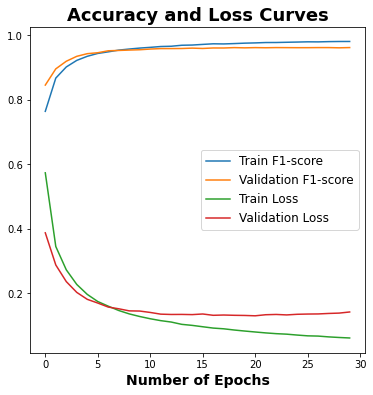

In [24]:
#Plot the Accuracy and Loss curves
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy and Loss Curves', fontweight='bold', fontsize=18)
# plt.ylabel('Accuracy & Loss', fontweight='bold', fontsize=13)
plt.xlabel('Number of Epochs', fontweight='bold', fontsize=14)
plt.legend(['Train F1-score', 'Validation F1-score', 'Train Loss', 'Validation Loss'], loc='right', fontsize=12)
plt.show()
fig.savefig('results/Model_F1-Score_and_Loss_Curves.png')

In [25]:
print('Test set performance')
test_perf = model.evaluate(X_test, Y_test)

Test set performance
853/853 [==============================] - 1s 1ms/step - loss: 0.1381 - accuracy: 0.9625


In [26]:
#Evaluate and create a Classification Report and save it
from sklearn.metrics import classification_report

# Assuming 'model' is your trained Keras model and 'x_test', 'y_test' are your test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)
y_true_classes = Y_test.argmax(axis=-1)

#Create Classification Report
print(classification_report(y_true_classes, y_pred_classes))
report = classification_report(y_true_classes, y_pred_classes, output_dict=True)

#Save it in csv
df_dnn = pd.DataFrame(report).transpose()
if input_type == "Byte":
    df_dnn.to_csv('results/DNN Report Byte.csv')
else:
    df_dnn.to_csv('results/DNN Report Char.csv')

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      9095
           1       0.96      0.97      0.97      9095
           2       0.96      0.98      0.97      9095

    accuracy                           0.96     27285
   macro avg       0.96      0.96      0.96     27285
weighted avg       0.96      0.96      0.96     27285



In [27]:
print(test_perf)

[0.13808844983577728, 0.9624702334403992]


In [28]:
# Passing the Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Using float-16 quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]

# Converting the model.
tflite_fp16_model = converter.convert()
 
# Saving the model.
with open('models/fp_16_model.tflite', 'wb') as f:
    f.write(tflite_fp16_model)

2023-08-21 14:12:27.477560: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp9sd4ipss/assets


2023-08-21 14:12:27.740177: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-08-21 14:12:27.740247: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-08-21 14:12:27.740533: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-21 14:12:27.880670: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-21 14:12:27.880849: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-21 14:12:27.880877: 

In [29]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Using  the Dynamic Range Quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Converting the model
tflite_quant_model = converter.convert()
# Saving the model.
with open('models/dynamic_quant_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpdgmvecoq/assets


INFO:tensorflow:Assets written to: /tmp/tmpdgmvecoq/assets
2023-08-21 14:12:28.260893: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-08-21 14:12:28.261010: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-08-21 14:12:28.261280: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-21 14:12:28.261516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-21 14:12:28.261676: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB devi

In [30]:
# Passing the baseline Keras model to the TF Lite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Defining the representative dataset from training images.
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_train).take(100):
        yield [input_value]

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Using Integer Quantization.
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
 
# Setting the input and output tensors to uint8.
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Converting the model.
int_quant_model = converter.convert()
 
# Saving the Integer Quantized TF Lite model.
with open('models/int_quant_model.tflite', 'wb') as f:
    f.write(int_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmphkxtrf48/assets


INFO:tensorflow:Assets written to: /tmp/tmphkxtrf48/assets
2023-08-21 14:12:28.640252: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 2
2023-08-21 14:12:28.640321: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-08-21 14:12:28.640544: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-21 14:12:28.640769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-08-21 14:12:28.640926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:68:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB devi

In [31]:
#Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
    prediction= []
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    input_format = interpreter.get_output_details()[0]['dtype']
    
    for i, test_image in enumerate(X_test):
        test_image = np.expand_dims(test_image, axis=0).astype(input_format)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        predicted_label = np.argmax(output()[0])
        prediction.append(predicted_label)

    print('\n')
    # Comparing prediction results with ground truth labels to calculate accuracy.
    prediction = np.array(prediction)

    accuracy = (prediction == Y_test1).mean()
    return accuracy

In [32]:
# Passing the FP-16 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('models/fp_16_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)



Float 16 Quantized TFLite Model Test Accuracy: 96.24702217335532


In [33]:
# Passing the Dynamic Range Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('models/dynamic_quant_model.tflite') 
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Dynamically Quantized TFLite Model Test Accuracy:', test_accuracy*100)



Dynamically Quantized TFLite Model Test Accuracy: 96.27634231262599


In [34]:
# Passing the Integer Quantized TF Lite model to the Interpreter.
interpreter = tf.lite.Interpreter('models/int_quant_model.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test images.
test_accuracy = evaluate(interpreter)
print('Integer Quantized TFLite Model Test Accuracy:', test_accuracy*100)



Integer Quantized TFLite Model Test Accuracy: 33.33333333333333


In [35]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [36]:
from sklearn.metrics import classification_report

def evaluate_model(model, name, feat_test, y_test, input_type="Byte"):
    """ Evaluate a classification model on the test set, then print and plot metrics. """
    # Make prediction from features
    pred_test = model.predict(feat_test)
    
    print(f"\n[ Evaluation result for {name} ]")
    # Print classification report
    print("Classification report:")
    print(classification_report(y_test, pred_test))
    report = classification_report(y_test, pred_test, output_dict=True)
    df = pd.DataFrame(report).transpose()
    # Save classification report as CSV
    df.to_csv('results/{} Report {}.csv'.format(name,input_type))

## Converting labels  to integer values
def label_to_numeric(row):
    """Convert label to integers"""
    distinct_labels = labels_to_integers.keys()
    index_ = distinct_labels.index(row["label"])
    return index_

In [37]:
def train_test_ML_models(df_train, df_test, input_type="Byte"):
    ## Visualize the dataset in tabular format
    print('Total Number of Training data samples:', df_train.shape[0])
    print('Total Number of Testing data samples:', df_test.shape[0])
    print('Number of features per data sample:', df_train.shape[1]-1)
    print('Distinct labels (Architecture Types):\n',label_counter.keys())
    
    df_train_tmp = copy.deepcopy(df_train)
    df_test_tmp = copy.deepcopy(df_test)
    
    df_train_tmp["label"] = df_train_tmp['label'].replace(labels_to_integers)
    df_test_tmp["label"] = df_test_tmp['label'].replace(labels_to_integers)

    #Train and Test labels
    y_train = df_train_tmp.pop("label").values
    y_test = df_test_tmp.pop("label").values
    
    #Train and Test data
    X_train = df_train_tmp.values
    X_test = df_test_tmp.values

    #SVM
    SVC_model = LinearSVC(random_state=123, max_iter=200)
    SVC_model.fit(X_train, y_train)
    classification_report = evaluate_model(SVC_model, "Support Vector Machine Classifier", X_test, y_test, input_type) 
    SVC_acc = np.round(SVC_model.score(X_test, y_test)*100,4)
    print(SVC_acc)

    #LR
    LR_model = LogisticRegression(random_state=123, max_iter =200)
    LR_model.fit(X_train, y_train)
    evaluate_model(LR_model, "Logistic Regression Classifier", X_test, y_test, input_type) 
    LR_acc = np.round(LR_model.score(X_test, y_test)*100,4)
    print(LR_acc)
    
    #GNB
    GNB_model = GaussianNB()
    GNB_model.fit(X_train, y_train)
    evaluate_model(GNB_model, "Gaussian Naive Bayes Classifier", X_test, y_test, input_type) 
    GNB_acc = np.round(GNB_model.score(X_test, y_test)*100,4)
    print(GNB_acc)

    #DT
    DT_model = DecisionTreeClassifier(random_state=1234567)
    DT_model.fit(X_train, y_train)
    evaluate_model(DT_model, "Decision Tree Classifier", X_test, y_test, input_type) 
    DT_acc = np.round(DT_model.score(X_test, y_test)*100,4)
    print(DT_acc)

#     RF
    RF_model = RandomForestClassifier(random_state=1234567)
    RF_model.fit(X_train, y_train)
    evaluate_model(RF_model, "Random Forest Classifier", X_test, y_test, input_type) 
    RF_acc = np.round(RF_model.score(X_test, y_test)*100,4)
    print(RF_acc)

For Byte Level TF-IDF - Train and Eval

In [38]:
if input_type == "Byte" or input_type == "All":
    train_test_ML_models(df_train_Byte_TFIDF_feat, df_test_Byte_TFIDF_feat, input_type="Byte")

For Char Level TF-IDF - Train and Eval

In [39]:
if input_type == "Char" or input_type == "All":
    train_test_ML_models(df_train_Char_TFIDF_feat, df_test_Char_TFIDF_feat, input_type="Char")

Total Number of Training data samples: 109137
Total Number of Testing data samples: 27285
Number of features per data sample: 273
Distinct labels (Architecture Types):
 dict_keys(['Spoofing', 'Normal', 'Fuzzing'])

[ Evaluation result for Support Vector Machine Classifier ]
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      9095
           1       0.77      0.73      0.75      9095
           2       0.94      0.97      0.95      9095

    accuracy                           0.82     27285
   macro avg       0.81      0.82      0.81     27285
weighted avg       0.81      0.82      0.81     27285

81.5027


/home/nsl/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



[ Evaluation result for Logistic Regression Classifier ]
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74      9095
           1       0.77      0.73      0.75      9095
           2       0.94      0.97      0.96      9095

    accuracy                           0.82     27285
   macro avg       0.81      0.82      0.81     27285
weighted avg       0.81      0.82      0.81     27285

81.5466

[ Evaluation result for Gaussian Naive Bayes Classifier ]
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.65      9095
           1       0.65      0.68      0.66      9095
           2       0.92      0.89      0.90      9095

    accuracy                           0.74     27285
   macro avg       0.74      0.74      0.74     27285
weighted avg       0.74      0.74      0.74     27285

73.6522

[ Evaluation result for Decision Tree Classifier ]
Classif